# RNN on RNA K-mers

Extract every K-mer for K=3.
Apply one-hot encoding.
Convert to ragged tensors.
Train with 3-deep RNN.

Previous runs exhausted RAM.
This version trains the same model additively on small batches of data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float32')  # save RAM

In [2]:
K=3   # K-mer length = word length

def showtime():
    now=datetime.now()
    current=now.strftime("%H:%M:%S")
    print("Time=",current)

showtime()
print("Build the model")
seq_len=None  # none indicates variable length
input_features=4**K   # 64 DNA K-mers at K=3
rnn2 = keras.models.Sequential([
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[seq_len,input_features]),
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.SimpleRNN(1),
])

showtime()
print("Build the training environment")
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
rnn2.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
rnn2.summary()

Build the model
Build the training environment
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 66        
Total params: 24,834
Trainable params: 24,834
Non-trainable params: 0
_________________________________________________________________


In [3]:
MIN_SEQ_LEN=200   ### by definition, lncRNA have min len 200
#MIN_SEQ_LEN=1000  ### we use this to reduce training RAM and CPU
MAX_SEQ_LEN=25000 ### this screens 4 outliers in the complete dataset
#MAX_SEQ_LEN=2000  ### we use this to reduce training RAM and CPU
DEFLINE='>'
ncfile='ncRNA.fasta' 
pcfile='pcRNA.fasta' 
#ncfile='tiny.ncRNA.fasta' # 10 seqs for faster debugging
#pcfile='tiny.pcRNA.fasta' # 10 seqs for faster debugging

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
## !ls drive/'My Drive'/'Colab Notebooks'/*
#ncfile='drive/My Drive/Colab Notebooks/ncRNA.fasta'
#pcfile='drive/My Drive/Colab Notebooks/pcRNA.fasta'

# Assume file was preprocessed to contain one line per seq.
# Returned structure is ndarray of ndarray i.e no python lists inside.
def load_fasta(filename,min_len,max_len):
    seqs=[]
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE and len(line)>min_len and len(line)<=max_len:
                line=line.rstrip()
                linelen=len(line)
                kmers=[]
                for i in range(linelen-K+1): # e.g. k=3,|line=4| => range=2 so i={0,1}
                    kmer=line[i:i+K]
                    kmers.append(kmer)
                kmers=np.array(kmers)
                seqs.append(kmers.reshape(-1, 1)) # reshaped changes (any,) to (any,1)
    nparray=np.array(seqs)
    return nparray

showtime()
print("Load "+ncfile)
nc_seqs = load_fasta(ncfile,MIN_SEQ_LEN,MAX_SEQ_LEN)
encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
#seq=tf.reshape(nc_seqs[0],shape=(-1, 1)) # tensor flow version
seq=nc_seqs[0].reshape(-1, 1)
encoder.fit(seq)
print("Encoder categories")
print(str(encoder.categories_))
nc_seqs = None
seq=None

Load ncRNA.fasta
Encoder categories
[array(['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA',
       'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC',
       'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG',
       'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT',
       'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA',
       'GTC', 'GTG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC',
       'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG',
       'TTT'], dtype='<U3')]


## Loop: additively train the model in small batches.

Epoch 0
Batch 0
Batch of RNA lengths 0 to 1000
Load ncRNA.fasta
Load pcRNA.fasta
Ecode the non-coding sequences
nc shape: (11415,)
Encode the protein-coding sequences
pc shape: (7270,)
shape of sequences, shape of labels
shape of train
(14948,) (14948,)
shape of test
(3737,) (3737,)
Convert numpy array to python 3D array
Partition = 11958
Partition train/validation
Lengths of train,valid
(11958, 2990)
Free memory.
Convert to tensors
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(11958, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(11958,)
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(2990, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(2990,)
Train the model
374/374 [==============================] - 497s 1s/step - loss: 3.1799 - accuracy: 0.5370 - val_loss: 2.0506 - val_accuracy: 0.5448
Visualize training history.


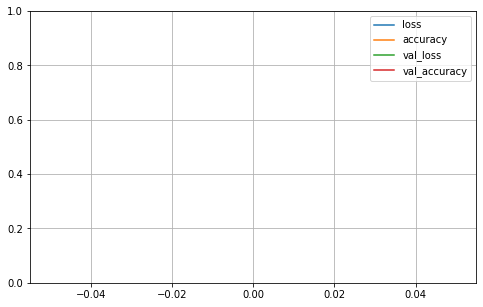

Batch 1
Batch of RNA lengths 1000 to 2000
Load ncRNA.fasta
Load pcRNA.fasta
Ecode the non-coding sequences
nc shape: (3758,)
Encode the protein-coding sequences


KeyboardInterrupt: 

In [4]:
EPOCHS=5
BATCHES=6
# batch max: 1K, 2K, 4K, 8K, 16K, 32K
for epoch in range(EPOCHS):
    print("Epoch %d"%epoch)
    batch_max = 0
    for batch in range(BATCHES):
        showtime()
        print ("Batch %d"%batch)
        batch_min = batch_max
        batch_max = 1000 * (2**batch)
        print("Batch of RNA lengths %d to %d"%(batch_min,batch_max))
        
        print("Load "+ncfile)
        nc_seqs = load_fasta(ncfile,batch_min,batch_max)
        print("Load "+pcfile)
        pc_seqs = load_fasta(pcfile,batch_min,batch_max)

        print("Ecode the non-coding sequences")
        nc_list=[]
        for seq in nc_seqs:
            encoded=encoder.transform(seq)  
            nc_list.append(encoded)

        nc_len=len(nc_list)
        nc_all=np.array(nc_list) # .reshape(-1,1)
        print("nc shape: "+str(nc_all.shape))

        print("Encode the protein-coding sequences")
        pc_list=[]
        for seq in pc_seqs:
            encoded=encoder.transform(seq)
            pc_list.append(encoded)

        pc_len=len(pc_list)
        pc_all=np.array(pc_list) # .reshape(-1,1)
        print("pc shape: "+str(pc_all.shape))
        
        nc_labels=np.zeros(shape=(nc_len))
        pc_labels=np.ones(shape=(pc_len))
        all_seqs=np.concatenate((nc_all,pc_all),axis=0)
        all_labels=np.concatenate((nc_labels,pc_labels),axis=0)

        print("shape of sequences, shape of labels")
        all_seqs.shape,all_labels.shape

        splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
        for train_index,test_index in splitter.split(all_seqs):
            train_seqs =   all_seqs[train_index]
            train_labels = all_labels[train_index]
            test_seqs =    all_seqs[test_index]
            test_labels =  all_labels[test_index]

        print("shape of train")
        print(train_seqs.shape,train_labels.shape)
        print("shape of test")
        print(test_seqs.shape,test_labels.shape)

        print("Convert numpy array to python 3D array")
        def numpy_to_python_3D(np_seqs):
            one_set = []
            tlen = len(np_seqs)
            for i in range(tlen): # for every sequence in set
                one_seq = []
                slen = len(np_seqs[i])
                for j in range(slen): # for ever letter in sequence
                    one_letter=np_seqs[i][j]
                    one_seq.append(one_letter)
                one_set.append(one_seq)
            return one_set
        train_seqs = numpy_to_python_3D(train_seqs)
        test_seqs = numpy_to_python_3D(test_seqs)
        train_labels = train_labels.tolist()
        test_labels = test_labels.tolist()

        # Now that values are shuffled, partition gives random sample.
        data_size=len(train_seqs)
        PARTITION=int(data_size*0.8)
        print("Partition = "+str(PARTITION))

        print("Partition train/validation")
        X_train=train_seqs[:PARTITION]
        X_valid=train_seqs[PARTITION:]
        y_train=train_labels[:PARTITION]
        y_valid=train_labels[PARTITION:]
        print("Lengths of train,valid")
        print((len(X_train),len(X_valid)))

        print("Free memory.")
        nc_list=None
        pc_list=None
        nc_all=None
        pc_all=None
        nc_seqs=None
        pc_seqs=None
        all_seqs=None
        nc_labels=None
        pc_labels=None
        train_seqs=None
        train_labels=None

        showtime()
        print("Convert to tensors")
        tensor = tf.ragged.constant(X_train)
        X_train = tensor
        tensor=None
        print(type(X_train))
        print(X_train.shape)
        tensor = tf.convert_to_tensor(y_train)
        y_train = tensor
        tensor=None
        print(type(y_train))
        print(y_train.shape)
        tensor = tf.ragged.constant(X_valid)
        X_valid=tensor
        tensor=None
        print(type(X_valid))
        print(X_valid.shape)
        tensor = tf.convert_to_tensor(y_valid)
        y_valid = tensor
        tensor=None
        print(type(y_valid))
        print(y_valid.shape)
        
        showtime()
        print("Resume training the model")
        history = rnn2.fit(X_train,y_train,epochs=1,
                           validation_data=(X_valid,y_valid))

In [ ]:
# Loss 3.7 to 3.2, accuracy .5 to .53

Resources.
[Working with RNNs](https://keras.io/guides/working_with_rnns/).
[Recurrent Neural Networks with Keras](https://www.tensorflow.org/guide/keras/rnn#rnns_with_listdict_inputs_or_nested_inputs).
Function tf.convert_to_tensor [docs](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor).
Function tf.reshape [docs](https://www.tensorflow.org/api_docs/python/tf/reshape).
Ragged Tensors [tutorial](https://www.tensorflow.org/guide/tensor#ragged_tensors)
and [docs](https://www.tensorflow.org/api_docs/python/tf/RaggedTensor#documenting_raggedtensor_shapes_2) and [module](https://www.tensorflow.org/api_docs/python/tf/ragged).
Incredible speedup for convert to tensor by sirfz on [stackoverflow](https://stackoverflow.com/questions/44353509/tensorflow-tf-constant-initializer-is-very-slow).


